In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn torch tensorflow xgboost

In [2]:
# -*- coding: utf-8 -*-
"""
Quantum Error Mitigation - GPU-Accelerated Stacking Ensemble
Combines: XGBoost + Neural Network + Random Forest
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
# ============================================================================
# GPU SETUP AND VERIFICATION
# ============================================================================

print("="*70)
print("GPU SETUP")
print("="*70)

# Check for GPU availability
import torch
import tensorflow as tf

# Check PyTorch GPU
if torch.cuda.is_available():
    print(f"✓ PyTorch GPU available: {torch.cuda.get_device_name(0)}")
    print(f"  CUDA Version: {torch.version.cuda}")
    print(f"  Number of GPUs: {torch.cuda.device_count()}")
    device = torch.device('cuda')
else:
    print("✗ PyTorch GPU not available, using CPU")
    device = torch.device('cpu')

# Check TensorFlow GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ TensorFlow GPU available: {len(gpus)} GPU(s)")
    for gpu in gpus:
        print(f"  {gpu}")
else:
    print("✗ TensorFlow GPU not available, using CPU")

# XGBoost GPU check
try:
    import xgboost as xgb
    print(f"✓ XGBoost version: {xgb.__version__}")
    print("  GPU training enabled with tree_method='gpu_hist'")
except ImportError:
    print("✗ XGBoost not installed")

print("="*70 + "\n")

GPU SETUP
✓ PyTorch GPU available: Tesla T4
  CUDA Version: 12.6
  Number of GPUs: 1
✓ TensorFlow GPU available: 1 GPU(s)
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
✓ XGBoost version: 3.1.2
  GPU training enabled with tree_method='gpu_hist'



In [4]:
# ============================================================================
# 1. LOAD AND PREPARE DATA
# ============================================================================

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/quantum_data.csv")

# Create error features
df["absolute_error"] = np.abs(df["x_ideal"] - df["x_noisy"])

# Feature Engineering - Add interaction terms
df["error_rate_x_depth"] = df["error_rate"] * df["depth"]
df["qubits_x_depth"] = df["num_qubits"] * df["depth"]
df["error_rate_squared"] = df["error_rate"] ** 2

print("Dataset shape:", df.shape)
print("\nTarget variable: x_ideal")
baseline_mae = mean_absolute_error(df["x_ideal"], df["x_noisy"])
print("Baseline MAE (no mitigation):", baseline_mae)


Dataset shape: (36450, 14)

Target variable: x_ideal
Baseline MAE (no mitigation): 0.046858032153495724


Create new interaction features

In [5]:
# ============================================================================
# 2. DEFINE FEATURES AND TARGET
# ============================================================================
df["x_noisy_x_num_qubits"] = df["x_noisy"] * df["num_qubits"]
df["x_noisy_x_depth"] = df["x_noisy"] * df["depth"]
df["x_noisy_x_error_rate"] = df["x_noisy"] * df["error_rate"]
df["x_noisy_x_qubits_x_error_x_depth"] = df["x_noisy"] * df["num_qubits"] * df["error_rate"] * df["depth"]

print("New interaction features created successfully.")
print(df[["x_noisy_x_num_qubits", "x_noisy_x_depth", "x_noisy_x_error_rate", "x_noisy_x_qubits_x_error_x_depth"]].head())

# Identify feature types
num_features = ["x_noisy", "error_rate", "depth", "num_qubits",
                "x_noisy_x_num_qubits","x_noisy_x_depth","x_noisy_x_error_rate",
                "x_noisy_x_qubits_x_error_x_depth",
                "error_rate_x_depth", "qubits_x_depth", "error_rate_squared"]
cat_features = ["noise_type", "entanglement", "observable_name"]

# Prepare X and y
X = df[num_features + cat_features]
y = df["x_ideal"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Further split train into train and validation for stacking
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42
)

print(f"\nBase train size: {len(X_train_base)}")
print(f"Validation size: {len(X_val_base)}")
print(f"Test size: {len(X_test)}")

New interaction features created successfully.
   x_noisy_x_num_qubits  x_noisy_x_depth  x_noisy_x_error_rate  \
0              0.061852         0.030926              0.000015   
1             -0.057640        -0.028820             -0.000014   
2              0.107902         0.053951              0.000027   
3             -1.113193        -0.556596             -0.000278   
4             -1.268320        -0.634160             -0.000317   

   x_noisy_x_qubits_x_error_x_depth  
0                          0.000124  
1                         -0.000115  
2                          0.000216  
3                         -0.002226  
4                         -0.002537  

Base train size: 21870
Validation size: 7290
Test size: 7290


In [6]:
# ============================================================================
# 3. BASE MODEL 1: XGBOOST (GPU)
# ============================================================================

print("\n" + "="*70)
print("BASE MODEL 1: XGBoost (GPU-Accelerated)")
print("="*70)

import time

# Label encode categorical features for XGBoost
def preprocess_for_xgboost(X_data, label_encoders=None, fit=False):
    X_processed = X_data.copy()
    if fit:
        label_encoders = {}
        for col in cat_features:
            le = LabelEncoder()
            X_processed[col] = le.fit_transform(X_processed[col])
            label_encoders[col] = le
    else:
        for col in cat_features:
            X_processed[col] = label_encoders[col].transform(X_processed[col])
    return X_processed, label_encoders

X_train_xgb, xgb_encoders = preprocess_for_xgboost(X_train_base, fit=True)
X_val_xgb, _ = preprocess_for_xgboost(X_val_base, xgb_encoders, fit=False)
X_test_xgb, _ = preprocess_for_xgboost(X_test, xgb_encoders, fit=False)

# XGBoost Model with GPU
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    tree_method='hist',
    device='cuda:0',
    predictor='gpu_predictor',
    random_state=42
)

print("\nTraining XGBoost on GPU...")
start_time = time.time()
xgb_model.fit(X_train_xgb, y_train_base)
xgb_time = time.time() - start_time
print(f"Training completed in {xgb_time:.2f} seconds")

# Generate predictions for stacking
xgb_val_pred = xgb_model.predict(X_val_xgb)
xgb_test_pred = xgb_model.predict(X_test_xgb)

print(f"XGBoost Validation MAE: {mean_absolute_error(y_val_base, xgb_val_pred):.6f}")
print(f"XGBoost Test MAE: {mean_absolute_error(y_test, xgb_test_pred):.6f}")



BASE MODEL 1: XGBoost (GPU-Accelerated)

Training XGBoost on GPU...
Training completed in 0.91 seconds
XGBoost Validation MAE: 0.036331
XGBoost Test MAE: 0.035601


In [7]:
# ============================================================================
# 4. BASE MODEL 2: NEURAL NETWORK (GPU - PyTorch)
# ============================================================================

print("\n" + "="*70)
print("BASE MODEL 2: Neural Network (GPU-Accelerated PyTorch)")
print("="*70)

# Preprocess data for Neural Network
scaler_num = StandardScaler()
X_train_nn_scaled = scaler_num.fit_transform(X_train_base[num_features])
X_val_nn_scaled = scaler_num.transform(X_val_base[num_features])
X_test_nn_scaled = scaler_num.transform(X_test[num_features])

# One-hot encode categorical
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_nn_cat = encoder.fit_transform(X_train_base[cat_features])
X_val_nn_cat = encoder.transform(X_val_base[cat_features])
X_test_nn_cat = encoder.transform(X_test[cat_features])

# Combine
X_train_nn = np.hstack([X_train_nn_scaled, X_train_nn_cat])
X_val_nn = np.hstack([X_val_nn_scaled, X_val_nn_cat])
X_test_nn = np.hstack([X_test_nn_scaled, X_test_nn_cat])

# Convert to tensors
X_train_nn_tensor = torch.FloatTensor(X_train_nn).to(device)
y_train_nn_tensor = torch.FloatTensor(y_train_base.values).to(device)
X_val_nn_tensor = torch.FloatTensor(X_val_nn).to(device)
X_test_nn_tensor = torch.FloatTensor(X_test_nn).to(device)

# Define PyTorch Neural Network
class QuantumErrorMitigationNN(torch.nn.Module):
    def __init__(self, input_size):
        super(QuantumErrorMitigationNN, self).__init__()
        # LSTM layer replaces fc1
        self.lstm = torch.nn.LSTM(input_size, 128, batch_first=True)
        self.bn_lstm = torch.nn.BatchNorm1d(128)

        self.fc2 = torch.nn.Linear(128, 64)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.fc3 = torch.nn.Linear(64, 32)
        self.bn3 = torch.nn.BatchNorm1d(32)
        self.fc4 = torch.nn.Linear(32, 16)
        self.bn4 = torch.nn.BatchNorm1d(16)
        self.fc5 = torch.nn.Linear(16, 1)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.2)

    def forward(self, x):
        # Reshape input for LSTM: (batch_size, sequence_length=1, num_features)
        x = x.unsqueeze(1) # Add sequence_length dimension
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :] # Take output from the last time step

        # Process through BatchNorm, ReLU and Dropout
        x = self.bn_lstm(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = self.fc5(x)
        return x

# Re-initialize model with the updated class definition
input_size = X_train_nn.shape[1]
nn_model = QuantumErrorMitigationNN(input_size).to(device)

print(f"\nUpdated Neural Network Architecture with LSTM:")
print(f"  Input: {input_size} \u2192 LSTM (128) \u2192 128 (BN) \u2192 64 (BN) \u2192 32 (BN) \u2192 16 (BN) \u2192 1")
print(f"  Device: {device}")
print(nn_model)
# Initialize model

print(f"\nNeural Network Architecture:")
print(f"  Input: {input_size} → 128 → 64 → 32 → 1")
print(f"  Device: {device}")

# Training setup
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10)

# Training loop
print("\nTraining Neural Network on GPU...")
start_time = time.time()
epochs = 150
batch_size = 256
best_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    nn_model.train()
    indices = torch.randperm(len(X_train_nn_tensor))
    epoch_loss = 0

    for i in range(0, len(X_train_nn_tensor), batch_size):
        batch_indices = indices[i:i+batch_size]
        X_batch = X_train_nn_tensor[batch_indices]
        y_batch = y_train_nn_tensor[batch_indices]

        optimizer.zero_grad()
        outputs = nn_model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Validation
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_nn_tensor).squeeze()
        val_loss = criterion(val_outputs, torch.FloatTensor(y_val_base.values).to(device)).item()

    scheduler.step(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        best_model_state = nn_model.state_dict().copy()
    else:
        patience_counter += 1

    if patience_counter >= 15:
        print(f"Early stopping at epoch {epoch+1}")
        break

nn_time = time.time() - start_time
print(f"Training completed in {nn_time:.2f} seconds")

# Load best model
nn_model.load_state_dict(best_model_state)

# Generate predictions for stacking
nn_model.eval()
with torch.no_grad():
    nn_val_pred = nn_model(X_val_nn_tensor).squeeze().cpu().numpy()
    nn_test_pred = nn_model(X_test_nn_tensor).squeeze().cpu().numpy()

print(f"Neural Network Validation MAE: {mean_absolute_error(y_val_base, nn_val_pred):.6f}")
print(f"Neural Network Test MAE: {mean_absolute_error(y_test, nn_test_pred):.6f}")


BASE MODEL 2: Neural Network (GPU-Accelerated PyTorch)

Updated Neural Network Architecture with LSTM:
  Input: 37 → LSTM (128) → 128 (BN) → 64 (BN) → 32 (BN) → 16 (BN) → 1
  Device: cuda
QuantumErrorMitigationNN(
  (lstm): LSTM(37, 128, batch_first=True)
  (bn_lstm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (bn4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

Neural Network Architecture:
  Input: 37 → 128 → 64 → 32 → 1
  Device: cuda

Tr

In [8]:
# ============================================================================
# 5. BASE MODEL 3: RANDOM FOREST
# ============================================================================

print("\n" + "="*70)
print("BASE MODEL 3: Random Forest")
print("="*70)

# Use same preprocessing as XGBoost
X_train_rf = X_train_xgb.copy()
X_val_rf = X_val_xgb.copy()
X_test_rf = X_test_xgb.copy()

# Random Forest Model
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print("\nTraining Random Forest...")
start_time = time.time()
rf_model.fit(X_train_rf, y_train_base)
rf_time = time.time() - start_time
print(f"Training completed in {rf_time:.2f} seconds")

# Generate predictions for stacking
rf_val_pred = rf_model.predict(X_val_rf)
rf_test_pred = rf_model.predict(X_test_rf)

print(f"Random Forest Validation MAE: {mean_absolute_error(y_val_base, rf_val_pred):.6f}")
print(f"Random Forest Test MAE: {mean_absolute_error(y_test, rf_test_pred):.6f}")



BASE MODEL 3: Random Forest

Training Random Forest...
Training completed in 14.43 seconds
Random Forest Validation MAE: 0.035307
Random Forest Test MAE: 0.035196


In [9]:
# ============================================================================
# 6. STACKING META-LEARNER
# ============================================================================

print("\n" + "="*70)
print("STACKING ENSEMBLE - META-LEARNER")
print("="*70)

# Create meta-features from base model predictions
meta_train = np.column_stack([xgb_val_pred, nn_val_pred, rf_val_pred])
meta_test = np.column_stack([xgb_test_pred, nn_test_pred, rf_test_pred])

print(f"\nMeta-features shape: {meta_train.shape}")
print("Meta-features: [XGBoost_pred, NN_pred, RF_pred]")

# Meta-learner: Ridge Regression
meta_learner = Ridge(alpha=1.0)

print("\nTraining meta-learner...")
start_time = time.time()
meta_learner.fit(meta_train, y_val_base)
meta_time = time.time() - start_time
print(f"Meta-learner training completed in {meta_time:.2f} seconds")

# Final stacked predictions
stacked_val_pred = meta_learner.predict(meta_train)
stacked_test_pred = meta_learner.predict(meta_test)

# Meta-learner weights
print("\n--- Meta-Learner Weights ---")
print(f"XGBoost weight: {meta_learner.coef_[0]:.4f}")
print(f"Neural Network weight: {meta_learner.coef_[1]:.4f}")
print(f"Random Forest weight: {meta_learner.coef_[2]:.4f}")
print(f"Intercept: {meta_learner.intercept_:.4f}")



STACKING ENSEMBLE - META-LEARNER

Meta-features shape: (7290, 3)
Meta-features: [XGBoost_pred, NN_pred, RF_pred]

Training meta-learner...
Meta-learner training completed in 0.03 seconds

--- Meta-Learner Weights ---
XGBoost weight: 0.1395
Neural Network weight: 0.4387
Random Forest weight: 0.4842
Intercept: -0.0013


In [10]:
# ============================================================================
# 7. COMPREHENSIVE EVALUATION
# ============================================================================

print("\n" + "="*70)
print("COMPREHENSIVE MODEL EVALUATION")
print("="*70)

# Calculate all metrics
models = {
    'Baseline (No Mitigation)': (df["x_noisy"].iloc[y_test.index], None),
    'XGBoost': (xgb_test_pred, xgb_time),
    'Neural Network': (nn_test_pred, nn_time),
    'Random Forest': (rf_test_pred, rf_time),
    'Stacked Ensemble': (stacked_test_pred, xgb_time + nn_time + rf_time + meta_time)
}

results = []
for name, (preds, train_time) in models.items():
    if name == 'Baseline (No Mitigation)':
        mae = baseline_mae
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        r2 = r2_score(y_test, preds)
        improvement = 0.0
    else:
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        r2 = r2_score(y_test, preds)
        improvement = ((baseline_mae - mae) / baseline_mae) * 100

    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'Improvement (%)': improvement,
        'Training Time (s)': train_time if train_time else 0
    })

results_df = pd.DataFrame(results)
print("\n" + results_df.to_string(index=False))


COMPREHENSIVE MODEL EVALUATION

                   Model      MAE     RMSE       R²  Improvement (%)  Training Time (s)
Baseline (No Mitigation) 0.046858 0.112830 0.877145         0.000000           0.000000
                 XGBoost 0.035601 0.072544 0.949214        24.023159           0.908622
          Neural Network 0.042067 0.081559 0.935807        10.225533          17.793514
           Random Forest 0.035196 0.073790 0.947454        24.887696          14.430314
        Stacked Ensemble 0.031889 0.068084 0.955266        31.945303          33.157944



GENERATING VISUALIZATIONS


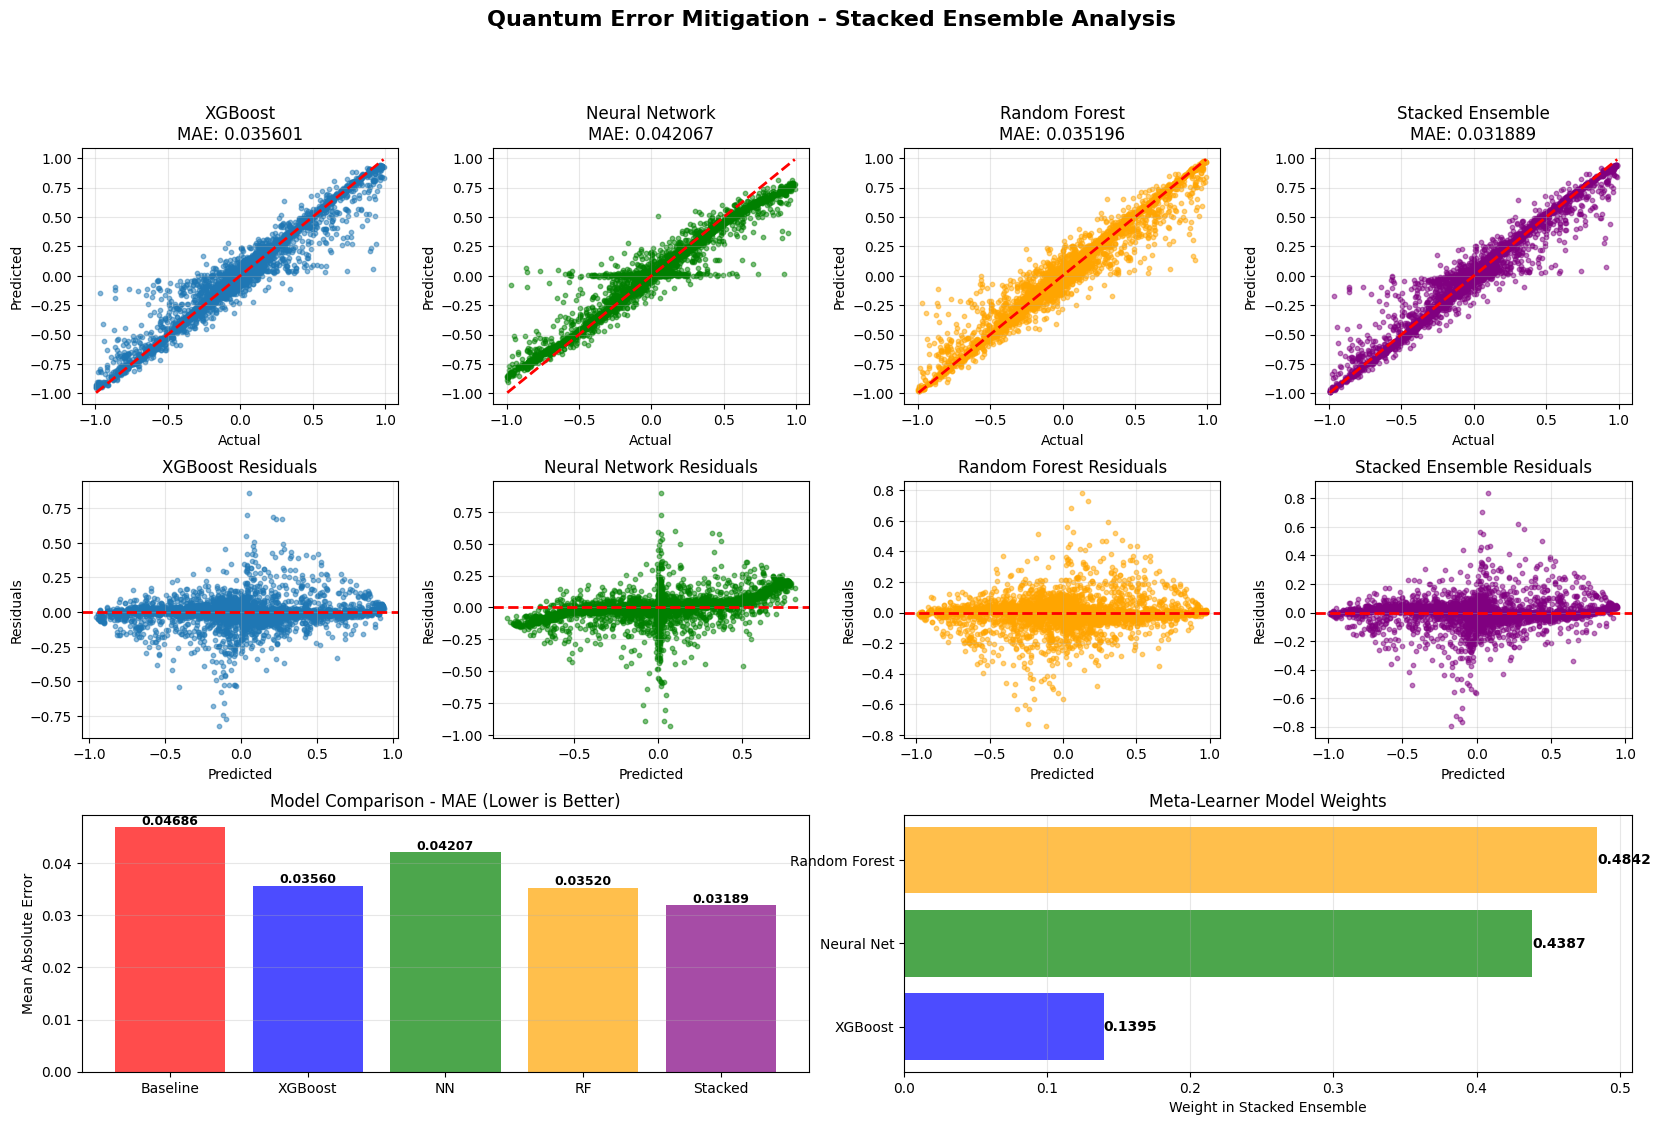

In [11]:
# ============================================================================
# 8. VISUALIZATION
# ============================================================================

print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# Row 1: Predicted vs Actual for each base model
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(y_test, xgb_test_pred, alpha=0.5, s=10)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set_title(f'XGBoost\nMAE: {mean_absolute_error(y_test, xgb_test_pred):.6f}')
ax1.grid(True, alpha=0.3)

ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(y_test, nn_test_pred, alpha=0.5, s=10, color='green')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set_title(f'Neural Network\nMAE: {mean_absolute_error(y_test, nn_test_pred):.6f}')
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(gs[0, 2])
ax3.scatter(y_test, rf_test_pred, alpha=0.5, s=10, color='orange')
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax3.set_xlabel('Actual')
ax3.set_ylabel('Predicted')
ax3.set_title(f'Random Forest\nMAE: {mean_absolute_error(y_test, rf_test_pred):.6f}')
ax3.grid(True, alpha=0.3)

ax4 = fig.add_subplot(gs[0, 3])
ax4.scatter(y_test, stacked_test_pred, alpha=0.5, s=10, color='purple')
ax4.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax4.set_xlabel('Actual')
ax4.set_ylabel('Predicted')
ax4.set_title(f'Stacked Ensemble\nMAE: {mean_absolute_error(y_test, stacked_test_pred):.6f}')
ax4.grid(True, alpha=0.3)

# Row 2: Residual plots
ax5 = fig.add_subplot(gs[1, 0])
ax5.scatter(xgb_test_pred, y_test - xgb_test_pred, alpha=0.5, s=10)
ax5.axhline(y=0, color='r', linestyle='--', lw=2)
ax5.set_xlabel('Predicted')
ax5.set_ylabel('Residuals')
ax5.set_title('XGBoost Residuals')
ax5.grid(True, alpha=0.3)

ax6 = fig.add_subplot(gs[1, 1])
ax6.scatter(nn_test_pred, y_test - nn_test_pred, alpha=0.5, s=10, color='green')
ax6.axhline(y=0, color='r', linestyle='--', lw=2)
ax6.set_xlabel('Predicted')
ax6.set_ylabel('Residuals')
ax6.set_title('Neural Network Residuals')
ax6.grid(True, alpha=0.3)

ax7 = fig.add_subplot(gs[1, 2])
ax7.scatter(rf_test_pred, y_test - rf_test_pred, alpha=0.5, s=10, color='orange')
ax7.axhline(y=0, color='r', linestyle='--', lw=2)
ax7.set_xlabel('Predicted')
ax7.set_ylabel('Residuals')
ax7.set_title('Random Forest Residuals')
ax7.grid(True, alpha=0.3)

ax8 = fig.add_subplot(gs[1, 3])
ax8.scatter(stacked_test_pred, y_test - stacked_test_pred, alpha=0.5, s=10, color='purple')
ax8.axhline(y=0, color='r', linestyle='--', lw=2)
ax8.set_xlabel('Predicted')
ax8.set_ylabel('Residuals')
ax8.set_title('Stacked Ensemble Residuals')
ax8.grid(True, alpha=0.3)

# Row 3: Performance comparison
ax9 = fig.add_subplot(gs[2, :2])
model_names = ['Baseline', 'XGBoost', 'NN', 'RF', 'Stacked']
mae_values = [results_df['MAE'].iloc[i] for i in range(5)]
colors = ['red', 'blue', 'green', 'orange', 'purple']
bars = ax9.bar(model_names, mae_values, color=colors, alpha=0.7)
ax9.set_ylabel('Mean Absolute Error')
ax9.set_title('Model Comparison - MAE (Lower is Better)')
ax9.grid(True, alpha=0.3, axis='y')
for i, (bar, val) in enumerate(zip(bars, mae_values)):
    height = bar.get_height()
    ax9.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.5f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

ax10 = fig.add_subplot(gs[2, 2:])
weights = [meta_learner.coef_[0], meta_learner.coef_[1], meta_learner.coef_[2]]
base_models = ['XGBoost', 'Neural Net', 'Random Forest']
bars = ax10.barh(base_models, weights, color=['blue', 'green', 'orange'], alpha=0.7)
ax10.set_xlabel('Weight in Stacked Ensemble')
ax10.set_title('Meta-Learner Model Weights')
ax10.grid(True, alpha=0.3, axis='x')
for i, (bar, val) in enumerate(zip(bars, weights)):
    width = bar.get_width()
    ax10.text(width, bar.get_y() + bar.get_height()/2.,
             f'{val:.4f}', ha='left', va='center', fontweight='bold')

plt.suptitle('Quantum Error Mitigation - Stacked Ensemble Analysis',
             fontsize=16, fontweight='bold', y=0.995)
plt.show()


In [12]:
# ============================================================================
# 9. SAVE ALL MODELS
# ============================================================================

print("\n" + "="*70)
print("SAVING MODELS")
print("="*70)

import pickle

# Save all models in a single dictionary
stacking_ensemble = {
    'xgb_model': xgb_model,
    'nn_model': nn_model,
    'rf_model': rf_model,
    'meta_learner': meta_learner,
    'xgb_encoders': xgb_encoders,
    'scaler': scaler_num,
    'encoder': encoder,
    'input_size': input_size
}

with open('stacked_qem_ensemble.pkl', 'wb') as f:
    pickle.dump(stacking_ensemble, f)
print("✓ Complete stacking ensemble saved as 'stacked_qem_ensemble.pkl'")


SAVING MODELS
✓ Complete stacking ensemble saved as 'stacked_qem_ensemble.pkl'


In [13]:
# ============================================================================
# 10. FINAL SUMMARY
# ============================================================================

print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

best_model_idx = results_df[results_df['Model'] != 'Baseline (No Mitigation)']['MAE'].idxmin()
best_model = results_df.loc[best_model_idx, 'Model']
best_mae = results_df.loc[best_model_idx, 'MAE']
best_improvement = results_df.loc[best_model_idx, 'Improvement (%)']

print(f"\n🏆 Best Model: {best_model}")
print(f"   MAE: {best_mae:.6f}")
print(f"   Improvement over baseline: {best_improvement:.2f}%")

stacked_improvement = results_df[results_df['Model'] == 'Stacked Ensemble']['Improvement (%)'].values[0]
print(f"\n📊 Stacked Ensemble Performance:")
print(f"   Improvement over baseline: {stacked_improvement:.2f}%")
print(f"   Training time: {results_df[results_df['Model'] == 'Stacked Ensemble']['Training Time (s)'].values[0]:.2f}s")

print("\n✓ GPU-accelerated stacking ensemble complete!")
print("✓ All models trained, evaluated, and saved successfully!")


FINAL SUMMARY

🏆 Best Model: Stacked Ensemble
   MAE: 0.031889
   Improvement over baseline: 31.95%

📊 Stacked Ensemble Performance:
   Improvement over baseline: 31.95%
   Training time: 33.16s

✓ GPU-accelerated stacking ensemble complete!
✓ All models trained, evaluated, and saved successfully!


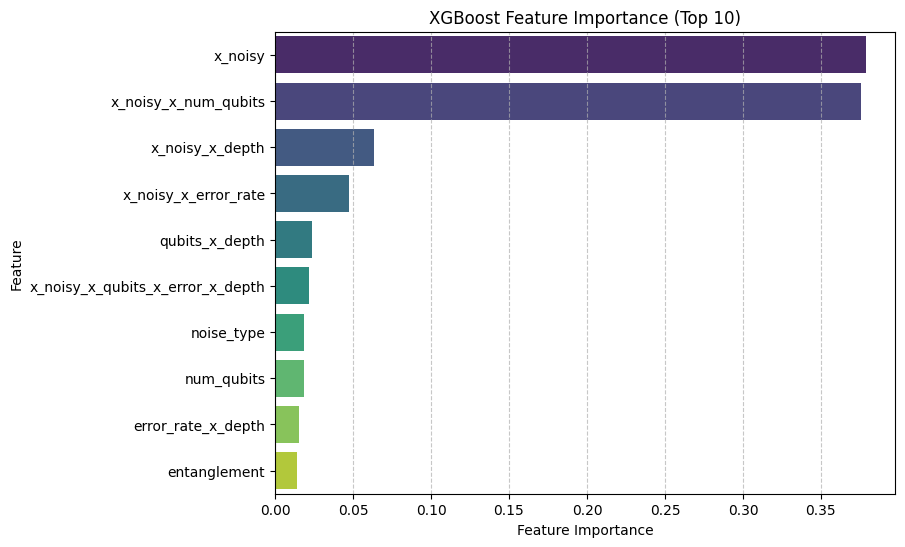

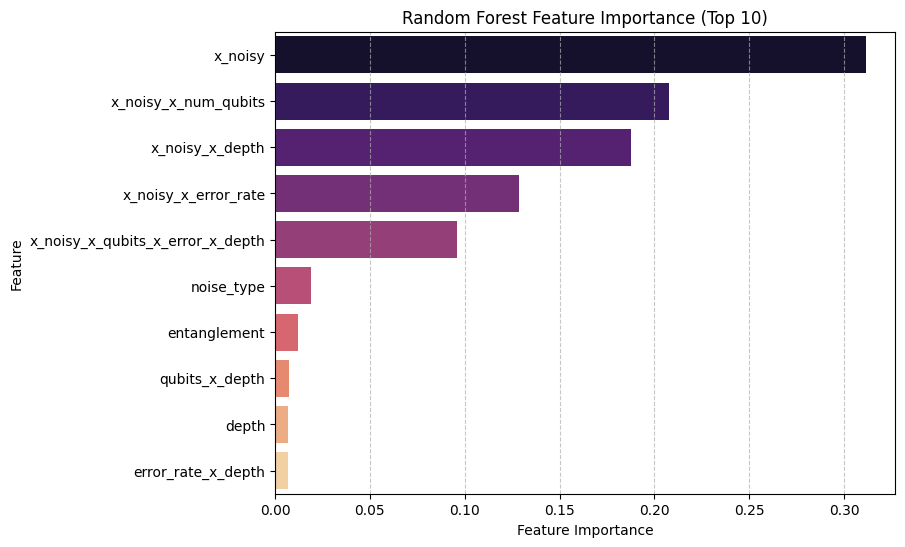

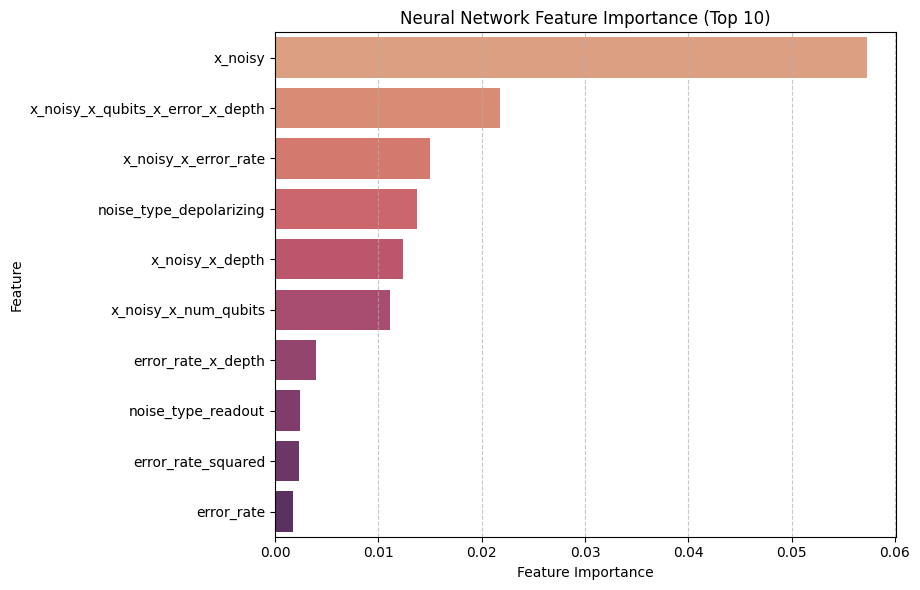

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import torch
import numpy as np
from sklearn.metrics import mean_squared_error

# Load the saved ensemble to access the models
with open('stacked_qem_ensemble.pkl', 'rb') as f:
    loaded_ensemble = pickle.load(f)

xgb_model = loaded_ensemble['xgb_model']
rf_model = loaded_ensemble['rf_model']
xgb_encoders = loaded_ensemble['xgb_encoders'] # Needed for X_train_xgb columns

# Recreate X_train_xgb and X_train_rf using the loaded encoders
# Assuming X_train_base and cat_features are still in scope from previous cells
# If not, these would also need to be loaded or recreated.

def preprocess_for_xgboost(X_data, label_encoders):
    X_processed = X_data.copy()
    for col in cat_features:
        X_processed[col] = label_encoders[col].transform(X_processed[col])
    return X_processed

def permutation_importance_nn(model, X, y, metric=mean_squared_error):
    model.eval()

    # Move X_tensor to the same device as the model
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    # y_tensor can remain on CPU for metric calculation, or moved to device if metric supports it
    y_tensor = torch.tensor(y.values, dtype=torch.float32).to(device) # Moved y_tensor to device for consistency

    with torch.no_grad():
        baseline_preds = model(X_tensor).cpu().numpy() # Move predictions back to CPU for numpy conversion

    baseline_score = metric(y_tensor.cpu().numpy(), baseline_preds) # Ensure y is also on CPU for metric

    importances = []

    # Create a DataFrame for feature names based on X_train_nn which was stacked
    nn_feature_names = num_features + list(encoder.get_feature_names_out(cat_features))

    for i, col_name in enumerate(nn_feature_names):
        X_permuted_np = X.copy() # Make a copy of the numpy array
        X_permuted_np[:, i] = np.random.permutation(X_permuted_np[:, i])

        # Move Xp_tensor to the same device as the model
        Xp_tensor = torch.tensor(X_permuted_np, dtype=torch.float32).to(device)

        with torch.no_grad():
            perm_preds = model(Xp_tensor).cpu().numpy() # Move predictions back to CPU for numpy conversion

        perm_score = metric(y_tensor.cpu().numpy(), perm_preds)
        importances.append(perm_score - baseline_score)

    return pd.DataFrame({
        'Feature': nn_feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)


X_train_xgb = preprocess_for_xgboost(X_train_base, xgb_encoders)
X_train_rf = X_train_xgb.copy()

# Get feature importance from XGBoost
xgb_feature_importances = xgb_model.feature_importances_
xgb_features = X_train_xgb.columns
xgb_importance_df = pd.DataFrame({
    'Feature': xgb_features,
    'Importance': xgb_feature_importances
}).sort_values(by='Importance', ascending=False)

# Get feature importance from Random Forest
rf_feature_importances = rf_model.feature_importances_
rf_features = X_train_rf.columns
rf_importance_df = pd.DataFrame({
    'Feature': rf_features,
    'Importance': rf_feature_importances
}).sort_values(by='Importance', ascending=False)
nn_perm_importance_df = permutation_importance_nn(
    model=nn_model,
    X=X_train_nn,
    y=y_train_base
)

# plt.figure(figsize=(16, 6))

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_importance_df.head(10), palette='viridis')
plt.title('XGBoost Feature Importance (Top 10)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=rf_importance_df.head(10), palette='magma')
plt.title('Random Forest Feature Importance (Top 10)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)



plt.figure(figsize=(9.3, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=nn_perm_importance_df.head(10),
    palette='flare'
)
plt.title('Neural Network Feature Importance (Top 10)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)



plt.tight_layout()
plt.show()

In [15]:
print("\n" + "="*70)
print("CLARIFYING MODEL PERFORMANCE IMPROVEMENT")
print("="*70)

# 1. Retrieve the Baseline MAE
baseline_mae = baseline_mae

# 2. Retrieve the Stacked Ensemble MAE
stacked_ensemble_mae = results_df[results_df['Model'] == 'Stacked Ensemble']['MAE'].values[0]

# 3. Calculate the absolute improvement
absolute_improvement = baseline_mae - stacked_ensemble_mae

# 4. Calculate the percentage improvement
percentage_improvement = (absolute_improvement / baseline_mae) * 100

# 5. Print the results
print(f"\nBaseline MAE: {baseline_mae:.6f}")
print(f"Stacked Ensemble MAE: {stacked_ensemble_mae:.6f}")
print(f"Absolute Reduction in MAE: {absolute_improvement:.6f}")
print(f"Percentage Improvement over Baseline: {percentage_improvement:.2f}%")

print("\nThis clarifies the actual percentage reduction in error achieved by the Stacked Ensemble model over the baseline.")


CLARIFYING MODEL PERFORMANCE IMPROVEMENT

Baseline MAE: 0.046858
Stacked Ensemble MAE: 0.031889
Absolute Reduction in MAE: 0.014969
Percentage Improvement over Baseline: 31.95%

This clarifies the actual percentage reduction in error achieved by the Stacked Ensemble model over the baseline.


In [16]:
print("\n" + "="*70)
print("CALCULATING MITIGATION FACTORS")
print("="*70)

# Ensure baseline_mae is accessible
# baseline_mae is already defined in previous cells

# Calculate Mitigation Factor for each model
results_df['Mitigation Factor'] = baseline_mae / results_df['MAE']

print("\nUpdated Results DataFrame with Mitigation Factors:")
display(results_df)


CALCULATING MITIGATION FACTORS

Updated Results DataFrame with Mitigation Factors:


,Model,MAE,RMSE,R²,Improvement (%),Training Time (s),Mitigation Factor
0,Baseline (No Mitigation),0.046858,0.112830,0.877145,0.000000,0.000000,1.000000
1,XGBoost,0.035601,0.072544,0.949214,24.023159,0.908622,1.316191
2,Neural Network,0.042067,0.081559,0.935807,10.225533,17.793514,1.113902
3,Random Forest,0.035196,0.073790,0.947454,24.887696,14.430314,1.331340
4,Stacked Ensemble,0.031889,0.068084,0.955266,31.945303,33.157944,1.469406
